**Thermo-Mechanical Transient Simulation using FEniCS**

**Objective:**
The objective of this exercise is to perform a thermo-mechanical transient simulation using the FEniCS finite element library. In this exercise, we will explore the coupling between thermal and mechanical phenomena in a time-dependent setting. The problem involves a 2D domain, and we will consider a linear elastic material model.

**Problem Description:**
Consider a 2D square domain Ω with dimensions LxL, where L = 1.0 m. The domain is initially at room temperature T_initial = 25°C. At t = 0, the left boundary (x = 0) is subjected to a temperature of T_boundary = 100°C, while the right boundary (x = L) is maintained at T_boundary = 50°C. The top (y = L) and bottom (y = 0) boundaries are assumed to be insulated, i.e., there is no heat flux through these boundaries.

The material properties are given in the following table:

| Property          | Symbol | Value        |
| ----------------- | ------ | ------------ |
| Young's modulus   | E      | 210e9 Pa     |
| Poisson's ratio   | ν      | 0.3          |
| Thermal expansion | α      | 1.2e-5 1/°C  |
| Conductivity      | k      | 50 W/(m°C)   |
| Density           | ρ      | 7800 kg/m³   |
| Specific heat     | c      | 480 J/(kg°C) |


**Tasks:**

1. Set up the 2D square domain Ω and define appropriate mesh resolution.
2. Implement a function to compute the temperature distribution within the domain over time using the heat equation.
3. Implement a function to compute the displacement field within the domain over time using the linear elasticity equations.
4. Perform a transient simulation, coupling the heat equation and linear elasticity equations, to obtain the temperature and displacement fields at different time steps.
5. Visualize the temperature and displacement fields at various time steps using appropriate visualization tools.
6. Analyze the results and observe the temperature and displacement evolution within the domain over time.

**Boundary Conditions:**

- Initial condition: T(x, y, 0) = T_initial for all points (x, y) within Ω.
- Left boundary condition: T(x = 0, y, t) = T_boundary for all y and t > 0.
- Right boundary condition: T(x = L, y, t) = T_boundary for all y and t > 0.
- Top and bottom boundary conditions: ∂T/∂y = 0 (insulated boundaries) for all x, t > 0.
- Displacement boundary conditions: u(x = 0, y, t) = 0 for all y and t > 0 (fixed boundary).

**Note:**
For the simulation, you can use an appropriate time-stepping scheme (e.g., Forward Euler, Backward Euler, or Crank-Nicolson) and consider suitable time intervals to observe the transient behavior effectively. You may also choose the finite element degree and other numerical parameters based on your understanding and computational resources.

Remember to interpret and analyze the results in light of the thermo-mechanical coupling and transient behavior exhibited by the system.


In [152]:
from dolfin import *
import matplotlib.pyplot as plt

# Material properties
E = 210e9  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio
alpha = 1.2e-5  # Thermal expansion (1/°C)
k = 50  # Conductivity (W/(m°C))
rho = 7800  # Density (kg/m³)
c = 480  # Specific heat (J/(kg°C))

In [153]:
lmbda = Constant(E*nu/((1+nu)*(1-2*nu)))
mu = Constant(E/2/(1+nu))

In [164]:

# Domain parameters
L = 1.0  # Length of the square domain (m)
T_initial = 25.0  # Initial temperature (°C)
T_boundary = 50.0  # Temperature at boundary (°C)
fixed_boundary = CompiledSubDomain("on_boundary")  # Fixed boundary at x=0

# Time parameters
T_end = 100.0  # End time of the simulation (s)
num_steps = 10  # Number of time steps
dt = T_end / num_steps  # Time step size

In [165]:
def eps(v):
    return sym(grad(v))
def sigma(v, dT):
    return (lmbda*tr(eps(v))- alpha*(3*lmbda+2*mu)*dT)*Identity(2) + 2.0*mu*eps(v)

In [166]:

# Create the mesh
nx = ny = 50  # Number of mesh points in each direction
mesh = RectangleMesh(Point(0, 0), Point(L, L), nx, ny)

# Define function spaces for temperature (scalar) and displacement (vector)
# Linear Lagrange element for temperature
P1 = FiniteElement("P", mesh.ufl_cell(), 1)
# Linear Lagrange element for displacement
P2 = VectorElement("P", mesh.ufl_cell(), 1)
# Combined function space for temperature and displacement
W = FunctionSpace(mesh, P1 * P2)

# Define trial and test functions
T, u = TrialFunctions(W)
dT, v = TestFunctions(W)

# Initial conditions for temperature and displacement
T_initial = Constant(T_initial)
u_initial = Constant((0, 0))

In [167]:
# Define the variational problem for temperature
T_new, u_new = Function(W).split()  # Temperature at the new time step
T_old, u_old = Function(W).split()  # Temperature at the new time step
T_old.assign(interpolate(T_initial, W.sub(0).collapse()))
u_old.assign(interpolate(u_initial, W.sub(1).collapse()))

In [168]:
T_mid = 0.5 * (T_old + T)  # Midpoint temperature for time-stepping

F_heat = rho * c * (T - T_old) / dt * dT * dx \
    + rho * c * dot(u_old, grad(T_mid)) * dT * dx \
    + k * dot(grad(T_mid), grad(dT)) * dx

# Define the variational problem for displacement
F_mech = inner(sigma(u, T_new), eps(v))*dx

form = F_heat+F_mech
# Apply the fixed boundary condition
bc_u = DirichletBC(W.sub(1), (0, 0), fixed_boundary)
bc_t = DirichletBC(W.sub(0), (T_boundary), fixed_boundary)
bc = [bc_u, bc_t]

In [169]:
ut_sol = Function(W)
# Time-stepping loop
for n in range(num_steps):
    # Update the current time
    t = (n + 1) * dt

    # Solve the heat equation to update the temperature field
    solve(lhs(form) == rhs(form), ut_sol, bc)
    T_new, u_new = ut_sol.split()

    # Update the current temperature and displacement for the next time step
    T_old.assign(project(T_new, W.sub(0).collapse()))
    u_old.assign(project(u_new, W.sub(1).collapse()))

  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.


In [170]:
t_sol, u_sol = ut_sol.split()

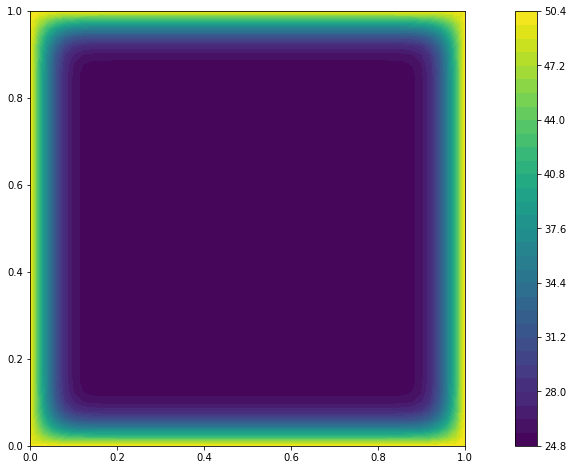

In [172]:
plt.figure(figsize=(18, 8))
p = plot(t_sol)
plt.colorbar(p)
plt.show()